In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
# Do I need this?
from pathlib import Path

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
#hawaii_path = Path("../Resources/hawaii.sqlite")
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
#engine = create_engine(f"sqlite:///{hawaii_path}")
conn = engine.connect()

In [22]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine,reflect=True)
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [33]:
# Query All Records in Hawaii measurement file
#measurement = pd.read_sql("SELECT * FROM measurement", conn)
#measurement.head()  
measurement = base.classes.measurement

In [34]:
# Query All Records in Hawaii station file
#station = pd.read_sql("SELECT * FROM station", conn)
#station.head()  
station = base.classes.station

In [10]:
# Save references to each table


In [35]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [27]:
# Find the most recent date in the data set.
most_recent = measurement["date"].max()
most_recent

'2017-08-23'

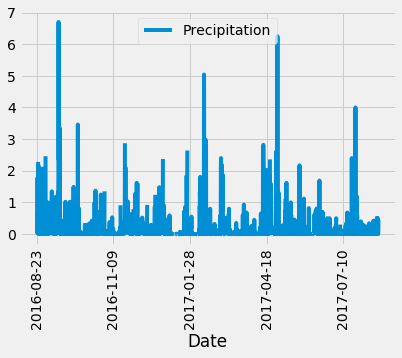

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
last_year = dt.date(2017,8,23)-dt.timedelta(days=365)
#last_year = datetime.strptime(last_year,"%y-%m-%d")
last_year

# Perform a query to retrieve the data and precipitation scores
#prcp_data = measurement[measurement["date"] >= last_year]
prcp_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(prcp_data, columns=["Date", "Precipitation"])

# Sort the dataframe by date
df = df.sort_values("Date")
df.head()
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x="Date", y="Precipitation", rot=90)

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [19]:
# Close Session
#session.close()

NameError: name 'session' is not defined